updated on 2022-12-16 by Xin, export the segmented kymographs
updated on 2022-1-13, 17:31 by Xin, setting the exact starting time point and ending time point for v-y averaging
updated on 2022-1-13, 18:04 by Xin, reusing the parameters from other replicates

## Inputs from you

In [307]:
treatment = ''
movie =  "H:\\PHD_data\\Imaging_et_analysis\\NikSD\\2023\\03_Mar\\21032023\\20230321_170413_923\\TimeSrs0001\\Pos0000\\ASCIIfiles\\"
piv_folder = "H:\\PHD_data\\Imaging_et_analysis\\NikSD\\2023\\03_Mar\\21032023\\20230321_170413_923\\TimeSrs0001\\Pos0000\\ASCIIfiles\\"

In [308]:
# parameter for segmenting the evl-ysl boundary
segmentation_threshold = 1

In [309]:
# parameter for the v-y-t plot (colorful plot)
what_to_plot = 'v'                             # 'vel' for velocity, 'v' for velocity on Y axis
color_map = 'RdYlGn'                           # other options like 'RdYlGn', 'seismic'
zero_centered = 1                              
set_color_range = [-4, 4]                      # max and min, color range of the v-y-t plot
                                               # if 0, automatically detect the max and min color of the velocity amp
                                               # example format [-2.5, 3.5]
to_save = 1
format_to_save = 'pdf'                         # other options like 'pdf', 'png'
time_window = 0                               # in minutes, if 0, then process the entire movie

# parameters for v-y plot
upper_boundary = -20          #um
lower_boundary = 50           #um
time_for_averaging = [5, 20]  #min, 0 for the entire movie, other formats like [5, 25], [0, 15]

In [310]:
# wanna reuse the settings from other replicates?
wanna_reuse_the_settings_from_other_replicates = 0

reuse_treatment = 'wt_depleted'
reuse_replicate = 'Nikon-03_Flows_TpmIn_221014_Movie5'

## Load the reused parameters

In [311]:
if wanna_reuse_the_settings_from_other_replicates:
    paramenter_in_that_replicate = reuse_treatment + '/' + reuse_replicate + '/v-y-t-plot-analysis-outputs/'+ reuse_replicate +'___analysis_info.xlsx'
    parementer_to_reuse = pd.read_excel(paramenter_in_that_replicate, index_col = 0)
    what_to_plot = parementer_to_reuse.values[3][0]
    color_map = parementer_to_reuse.values[4][0]
    zero_centered = parementer_to_reuse.values[5][0]                           
    set_color_range = parementer_to_reuse.values[6][0][1:-1]
    where_is_the_comma = set_color_range.index(',')
    set_color_range = [int(set_color_range[:where_is_the_comma]), int(set_color_range[where_is_the_comma+2:])]
    format_to_save =  parementer_to_reuse.values[7][0]
    time_window = parementer_to_reuse.values[10][0]
    upper_boundary = parementer_to_reuse.values[13][0] 
    lower_boundary = parementer_to_reuse.values[14][0]
    time_for_averaging =parementer_to_reuse.values[15][0][1:-1]
    where_is_the_comma = time_for_averaging.index(',')
    time_for_averaging = [int(time_for_averaging[:where_is_the_comma]), int(time_for_averaging[where_is_the_comma+2:])]

## Load the basic packages, define the pre-processing of PIVlab txt data

In [312]:
data_files = []

for i in os.listdir(piv_folder):
    if '.txt' in i and 'PIVlab' in i:
        data_files.append(i)
    
frame_num = len(data_files)
print('There are ' + str(frame_num) + ' frames in this movie.')

There are 19 frames in this movie.


In [313]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import skimage.io
import datetime
from scipy.ndimage import gaussian_filter
import pandas as pd
from scipy.signal import find_peaks
from scipy import stats
import math

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.family'] = 'Arial'
mpl.rc('xtick', labelsize=6) 
mpl.rc('ytick', labelsize=6) 

def create_folder(path):
    isExist = os.path.exists(path) 
    if not isExist:
        os.makedirs(path)

def piv_lab_rearrange(folder, pixel_size, t_interval, every = None):
        
    data_files = []

    for i in os.listdir(folder):
        if '.txt' in i and 'PIVlab' in i:
            data_files.append(i)
    
    frame_num = len(data_files)
    
    x2 = [[]]*frame_num
    y2 = [[]]*frame_num
    u2 = [[]]*frame_num
    v2 = [[]]*frame_num
    
    with open(folder + '/PIVlab_0001.txt') as f:
        first_line = f.readline()
    if first_line[:6] == "x [px]":
        header = 0
    else:
        header = 2

    for frame in range(1,frame_num+1):
        
        if frame < 10:
            frame_name = '000' + str(frame)
        elif frame >=10 and frame < 100:
            frame_name = '00' + str(frame)
        elif frame >= 100:
            frame_name = '0' + str(frame)
            
        data = pd.read_csv(folder + '/PIVlab_'+ frame_name + '.txt',
                            sep=",", header=header)#.fillna(0)
        x2[frame-1] = np.array(data['x [px]'])
        y2[frame-1] = np.array(data['y [px]'])
        u2[frame-1] = np.array(data['u [px/frame]'])
        v2[frame-1] = np.array(data['v [px/frame]'])
        # u2[frame-1][np.isnan(u2[frame-1])] = 0
        # v2[frame-1][np.isnan(v2[frame-1])] = 0
        
    x2 = np.array(x2)
    y2 = np.array(y2)
    u2 = np.array(u2) * pixel_size / t_interval 
    v2 = -np.array(v2) * pixel_size / t_interval 
    
    # x3y3 shape: x*y    
    x3 = np.unique(x2)
    y3 = np.unique(y2)    
    
    # xy shape: x, y
    # uv shape: t, x, y
    # vel shape: t, x, y
    x = x2[0].reshape(len(x3), len(y3))
    y = y2[0].reshape(len(x3), len(y3))
    u = u2.reshape(frame_num, len(x3), len(y3))
    v = v2.reshape(frame_num, len(x3), len(y3))
    
    # x2y2u2v2vel2 shape: t, x*y
    u2 = np.nan_to_num(u2)
    v2 = np.nan_to_num(v2)
    
    vel = np.sqrt(v**2 + u**2)
    vel2 = np.nan_to_num(vel.reshape(frame_num, len(y3)*len(x3)))
    
    class Piv_data_rearranged:
        def __init__(self, t_interval, frame_num, x, y, u, v, vel, x2, y2, u2, v2, vel2, x3, y3):
            self.t = np.arange(frame_num-1) * t_interval
            self.f = frame_num
            self.x, self.y, self.u, self.v = x,y,u,v
            self.x2, self.y2, self.u2, self.v2 = x2,y2,u2,v2
            self.x3, self.y3 = x3, y3
            self.vel, self.vel2 = vel, vel2
        
    data = Piv_data_rearranged(t_interval, frame_num, x, y, u, v, vel, x2, y2, u2, v2, vel2, x3, y3)
    print('shape of [ x y ]: x, y' + '\n' +
          'shape of [ u v vel ]: t, x, y' + '\n' +
          'shape of [ x2 y2 u2 v2 vel2 ]: t, x*y' + '\n'
          'shape of [ x3 y3 ]: x*y')
    
    return data


def evl_ysl_boundary_analysis(kymo, pixel_size, t_interval, to_save=False, segmentationthreshold=1):

    frames, height = kymo.shape

    #find the boundary    
    evl_ysl_boundary = np.empty(frames)
    for f in range(frames):
        intensity_profile_f = kymo[f]
        intensity_profile_f_gaussian = gaussian_filter(intensity_profile_f, sigma = 5)
        maxima, _ = find_peaks(intensity_profile_f_gaussian)
        for max_point in maxima:
            if intensity_profile_f_gaussian[max_point] > np.mean(intensity_profile_f_gaussian[maxima])*segmentationthreshold:
                break
        evl_ysl_boundary[f] = max_point
        
        # fig, ax = plt.subplots()
        # ax.plot(intensity_profile_f)
        # ax.plot(intensity_profile_f_gaussian)
        # ax.scatter(maxima, intensity_profile_f_gaussian[maxima], color = 'lawngreen')
        # ax.scatter(max_point, intensity_profile_f_gaussian[max_point], color = 'red')
        # ax.set_title('frame' + str(f))
        # plt.show()
    
    #plot the boundary in the kymograph
    fig, ax = plt.subplots(figsize=[3,3])
    ax.imshow(kymo, aspect = 'auto',
              extent = (0, height*pixel_size, frames*t_interval/60, 0))
    ax.plot(evl_ysl_boundary*pixel_size, (np.arange(frames)+0.5)*t_interval/60,
            color = 'red', ls = '--')
    ax.set_xlabel('Y axis (\u03BCm)', fontsize = 9)
    ax.set_ylabel('Time (min)', fontsize = 9)
    if to_save:
        plt.savefig(output_folder+'/' +'___kymograph_with_boundary.' + format_to_save)
    else:
        plt.show()

    #correct based on the gap
    gap_correction = (evl_ysl_boundary.max() - evl_ysl_boundary).astype('int')
    # new_height = int(kymo.shape[1]*2 - evl_ysl_boundary.min())
    new_height = int(height + gap_correction.max())
    new_kymo = np.empty([frames, new_height])
    new_kymo[:]=np.nan
    for f in range(frames):
        new_kymo[f, gap_correction[f]:(gap_correction[f]+height)] = kymo[f]
    #plot the corrected kymograph
    fig, ax = plt.subplots(figsize=[3,3])
    ax.imshow(new_kymo, aspect = 'auto',
              extent = (-evl_ysl_boundary.max()* pixel_size,
                        (height-evl_ysl_boundary.min())*pixel_size,
                        frames*t_interval/60, 0))
    ax.axvline(x = 0, color = 'red', ls = '--')
    ax.set_xlabel('Distance from EVL margin (\u03BCm)', fontsize = 9)
    ax.set_ylabel('Time (min)', fontsize = 9)
    if to_save:
        plt.savefig(output_folder+'/'+'___kymograph_with_boundary__corrected.' + format_to_save)
    else:
        plt.show()
    
    x = (np.arange(frames)*t_interval/60)[:-1]
    y = (evl_ysl_boundary * pixel_size)[:-1]
    
    res = stats.linregress(x, y)
    evl_ysl_boundary_speed = res.slope
    evl_ysl_boundary_start = res.intercept
    print("Speed of EVL-YSL boundary movement: " + str(evl_ysl_boundary_speed) +" \u03BCm/min")
    
    return evl_ysl_boundary, [evl_ysl_boundary_speed, evl_ysl_boundary_start]

def find_closest(array, target_array):
    indices = []
    for i in array:
        compared_array = np.abs(target_array - i)
        index = np.where(compared_array == compared_array.min())[0][0]
        indices.append(index)
    indices = np.array(indices, dtype = 'int')
    return indices

## create a folder for the analysis output

In [318]:
output_folder = movie + '/v-y-t-plot-analysis-outputs'
print(output_folder)
create_folder(output_folder)

H:\PHD_data\Imaging_et_analysis\NikSD\2023\03_Mar\21032023\20230321_170413_923\TimeSrs0001\Pos0000\ASCIIfiles\/v-y-t-plot-analysis-outputs


## Read the metadata of the movie

image_metadata = pd.read_excel( movie + '/metadata.xlsx', header=None, index_col=None)

pixel_size = image_metadata.iloc[0,1] # um
time_interval = image_metadata.iloc[1,1] # sec

## Load the PIV lab data

In [319]:
pixel_size=0.2166
time_interval=29.97

In [320]:
### Load 
Piv = piv_lab_rearrange(piv_folder, pixel_size, time_interval)
x, y, u, v = Piv.x, Piv.y, Piv.u*60, Piv.v*60
x3, y3 = Piv.x3, Piv.y3
t = Piv.t
vel, vel2 = Piv.vel*60, Piv.vel2*60

### 
if time_window == 0:
    f = Piv.f
    print('PIV.f: ' + str(f))
    time_window_num=f
else:
    time_window_num = math.ceil(time_window*60/time_interval)
    f=time_window_num
    
print('Time window num: ' + str(f))

shape of [ x y ]: x, y
shape of [ u v vel ]: t, x, y
shape of [ x2 y2 u2 v2 vel2 ]: t, x*y
shape of [ x3 y3 ]: x*y
PIV.f: 19
Time window num: 19


## Import the kymograph, segment the boundary, analyze the boundary movement

(19, 1024)
Speed of EVL-YSL boundary movement: 0.4761467349702652 μm/min


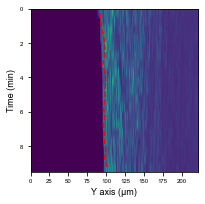

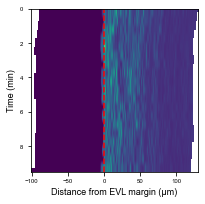

In [322]:
kymo = skimage.io.imread( movie + '/kymo.tif')[:f]
_, image_height = kymo.shape
print(kymo.shape)
evl_ysl_boundary, [speed, evl_ysl_start] = evl_ysl_boundary_analysis(kymo, pixel_size, time_interval,
                                                                     to_save = to_save,
                                                                     segmentationthreshold = segmentation_threshold)

## Plot the EVL-YSL boundary movements

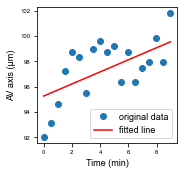

In [323]:
x = (np.arange(kymo.shape[0])*time_interval/60)
y = evl_ysl_boundary * pixel_size

### save the data
evl_ysl_boundary_export = pd.DataFrame({'time (min)':x, 'boundary position (um)': y})
evl_ysl_boundary_export.to_csv(movie +'/evl_ysl_boundary_position_time.csv')
    
fig, ax = plt.subplots(figsize = [2.5 ,2.5])
ax.plot(x, y, 'o', label='original data')
ax.plot(x, evl_ysl_start + speed*x, 'r', label='fitted line')
ax.set_xlabel('Time (min)', fontsize = 9)
ax.set_ylabel('AV axis (\u03BCm)', fontsize = 9)
ax.legend(fontsize = 9)
if to_save:
    plt.savefig(output_folder +'/evl_ysl_boundary_position_time.' + format_to_save)
else:
    plt.show()

## Plot the profile of cortical flow of THE ENTIRE MOVIE, with the boundary

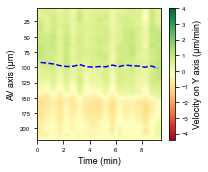

In [324]:
# Rearange the data into <v as a function of time>

y_num = len(y3)
v_t = np.empty(shape = [y_num,f])

for frame in range(f):

    if what_to_plot == 'v':
        v_t[:,frame] = np.nanmean(-v[frame], axis = 0)
    elif what_to_plot == 'vel':
        v_t[:,frame] = np.nanmean(vel[frame], axis = 0)*np.sign(-np.nanmean(v[frame], axis = 0))

if set_color_range == 0: 
    if zero_centered:
        cmap_scale = max(abs(v_t.max()), abs(v_t.min()))
        cmap_scale_neg = -cmap_scale
    else:
        cmap_scale, cmap_scale_neg = None, None
else:
    cmap_scale, cmap_scale_neg = set_color_range

    
# Plot <v as a function of time>   WITH the boundary
fig, ax = plt.subplots(figsize = (3,2.5))
kymograph_v_t = ax.imshow(v_t,
                      cmap = color_map,
                      #  interpolation = 'bicubic',
                      aspect = 'auto',
                      extent = (0, f*time_interval/60, max(y3)*pixel_size, min(y3)*pixel_size),
                      vmax = cmap_scale, vmin = cmap_scale_neg
                      )

ax.plot((np.arange(f)+0.5)*time_interval/60, evl_ysl_boundary[:f]*pixel_size, color = 'blue', ls = '--')

ax.set_xlabel('Time (min)', fontsize = 9)
ax.set_ylabel('AV axis (\u03BCm)', fontsize = 9)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(kymograph_v_t, cax=cax)
cbar.ax.set_ylabel('Velocity on Y axis (\u03BCm/min)', fontsize = 9)
plt.tight_layout()
if to_save:
    plt.savefig(output_folder+'/'+'___v-y-t_plot__timewindow'+str(time_window)+'min_with_boundary.'+ format_to_save)
else:
    plt.show()

## Plot the profile of cortical flow of THE ENTIRE MOVIE, with the boundary corrected

In [325]:
evl_ysl_boundary_corrected_index_on_y3 = find_closest(evl_ysl_boundary[:f], y3)
evl_ysl_boundary_corrected = y3[evl_ysl_boundary_corrected_index_on_y3]

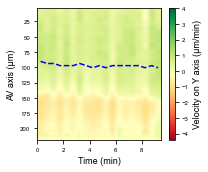

In [326]:
# Rearange the data into <v as a function of time>

y_num = len(y3)
v_t = np.empty(shape = [y_num,f])

for frame in range(f):
    if what_to_plot == 'v':
        v_t[:,frame] = np.nanmean(-v[frame], axis = 0)
    elif what_to_plot == 'vel':
        v_t[:,frame] = np.nanmean(vel[frame], axis = 0)*np.sign(-np.nanmean(v[frame], axis = 0))

if set_color_range == 0: 
    if zero_centered:
        cmap_scale = max(abs(v_t.max()), abs(v_t.min()))
        cmap_scale_neg = -cmap_scale
    else:
        cmap_scale, cmap_scale_neg = None, None
else:
    cmap_scale, cmap_scale_neg = set_color_range

    
# Plot <v as a function of time>   WITH the boundary
fig, ax = plt.subplots(figsize = (3,2.5))
kymograph_v_t = ax.imshow(v_t,
                      cmap = color_map,
                      #  interpolation = 'bicubic',
                      aspect = 'auto',
                      extent = (0, f*time_interval/60, max(y3)*pixel_size, min(y3)*pixel_size),
                      vmax = cmap_scale, vmin = cmap_scale_neg
                      )

ax.plot((np.arange(f)+0.5)*time_interval/60, evl_ysl_boundary_corrected*pixel_size, color = 'blue', ls = '--')

ax.set_xlabel('Time (min)', fontsize = 9)
ax.set_ylabel('AV axis (\u03BCm)', fontsize = 9)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(kymograph_v_t, cax=cax)
cbar.ax.set_ylabel('Velocity on Y axis (\u03BCm/min)', fontsize = 9)
plt.tight_layout()
if to_save:
    plt.savefig(output_folder+'/'+'___v-y-t_plot__timewindow'+str(time_window)+'min_with_boundary_corrected.' + format_to_save)
else:
    plt.show()



## Plot the profile of cortical flow of THE ENTIRE MOVIE corrected

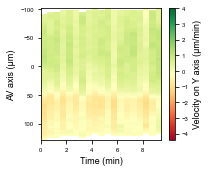

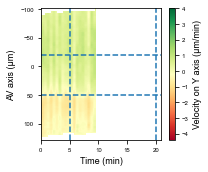

In [327]:
y_num_corrected = len(y3) + evl_ysl_boundary_corrected_index_on_y3.max() - evl_ysl_boundary_corrected_index_on_y3.min()

v_t_corrected = np.empty(shape = [y_num_corrected,f])
v_t_corrected[:] = np.nan

new_start = (-evl_ysl_boundary_corrected.max())*pixel_size
new_end = (max(y3) - evl_ysl_boundary_corrected.min())*pixel_size

for frame in range(f):
    correction_movement = int(evl_ysl_boundary_corrected_index_on_y3.max() - evl_ysl_boundary_corrected_index_on_y3[frame])
    v_t_corrected[correction_movement:correction_movement+len(y3), frame] = v_t[:, frame]

if set_color_range == 0: 
    if zero_centered:
        cmap_scale = max(abs(v_t.max()), abs(v_t.min()))
        cmap_scale_neg = -cmap_scale
    else:
        cmap_scale, cmap_scale_neg = None, None
else:
    cmap_scale, cmap_scale_neg = set_color_range


# Plot <v as a function of time>   WITH the boundary
fig, ax = plt.subplots(figsize = (3,2.5))
kymograph_v_t = ax.imshow(v_t_corrected,
                      cmap = color_map,
                      #  interpolation = 'bicubic',
                      aspect = 'auto',
                      extent = (0, f*time_interval/60, new_end, new_start),
                      vmax = cmap_scale, vmin = cmap_scale_neg
                      )

# ax.plot((np.arange(f)+0.5)*time_interval/60, evl_ysl_boundary_corrected*pixel_size, color = 'blue', ls = '--')

ax.set_xlabel('Time (min)', fontsize = 9)
ax.set_ylabel('AV axis (\u03BCm)', fontsize = 9)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(kymograph_v_t, cax=cax)
cbar.ax.set_ylabel('Velocity on Y axis (\u03BCm/min)', fontsize = 9)
plt.tight_layout()
if to_save:
    plt.savefig(output_folder+'/' +'___v-y-t_plot__timewindow'+str(time_window)+'min_corrected.' + format_to_save)
else:
    plt.show()
    
    
# Plot <v as a function of time>   WITH the boundaries to be averaged for v-y plot
fig, ax = plt.subplots(figsize = (3,2.5))
kymograph_v_t = ax.imshow(v_t_corrected,
                      cmap = color_map,
                      #  interpolation = 'bicubic',
                      aspect = 'auto',
                      extent = (0, f*time_interval/60, new_end, new_start),
                      vmax = cmap_scale, vmin = cmap_scale_neg
                      )

ax.set_xlabel('Time (min)', fontsize = 9)
ax.set_ylabel('AV axis (\u03BCm)', fontsize = 9)

ax.axhline(y = lower_boundary, linestyle = '--')
ax.axhline(y = upper_boundary, linestyle = '--')
if time_for_averaging !=0:
    ax.axvline(x = time_for_averaging[0], linestyle = '--')
    ax.axvline(x = time_for_averaging[-1], linestyle = '--')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(kymograph_v_t, cax=cax)
cbar.ax.set_ylabel('Velocity on Y axis (\u03BCm/min)', fontsize = 9)
plt.tight_layout()
plt.show()


## Do the v-y plot

In [328]:
if time_for_averaging == 0:
    frames_for_averaging_start = 0
    frames_for_averaging_end = time_window_num
else:     
    frames_for_averaging_start = math.floor(time_for_averaging[0]*60/time_interval)
    frames_for_averaging_end = math.ceil(time_for_averaging[1]*60/time_interval)

data_export_upper_boundary_pixel = math.ceil(upper_boundary/pixel_size/(y3[1]-y3[0]))
data_export_lower_boundary_pixel = math.floor(lower_boundary/pixel_size/(y3[1]-y3[0]))+1

In [329]:
new_av_axis = (np.arange(y_num_corrected) - evl_ysl_boundary_corrected_index_on_y3[0]
               - y_num_corrected + len(y3) )* (y3[1]-y3[0]) * pixel_size

v_t_corrected_avg = np.nanmean(v_t_corrected[:,frames_for_averaging_start:frames_for_averaging_end], axis = 1)
v_t_corrected_std = np.nanstd(v_t_corrected[:,frames_for_averaging_start:frames_for_averaging_end], axis = 1)

boundary_position = np.where(new_av_axis==0)[0][0]

C:\Users\snaik\AppData\Local\Temp\ipykernel_13800\2221013886.py:4: RuntimeWarning: Mean of empty slice
  v_t_corrected_avg = np.nanmean(v_t_corrected[:,frames_for_averaging_start:frames_for_averaging_end], axis = 1)
c:\Miniconda\envs\snBase\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


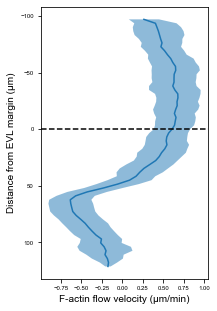

In [330]:
fig, ax = plt.subplots(figsize = [3,5])
ax.plot(v_t_corrected_avg, new_av_axis)
ax.fill_betweenx(y = new_av_axis,
                x1 = v_t_corrected_avg - v_t_corrected_std,
                x2 = v_t_corrected_avg + v_t_corrected_std,
                alpha = 0.5)
ax.axhline(y = 0, color = 'black', ls = '--')
ax.invert_yaxis()
# ax.set_ylim(50, -25)
ax.set_xlabel('F-actin flow velocity (\u03BCm/min)')
ax.set_ylabel('Distance from EVL margin (\u03BCm)')
plt.show()

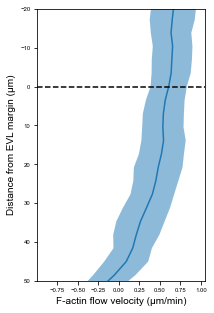

In [331]:
fig, ax = plt.subplots(figsize = [3,5])
ax.plot(v_t_corrected_avg, new_av_axis)
ax.fill_betweenx(y = new_av_axis,
                x1 = v_t_corrected_avg - v_t_corrected_std,
                x2 = v_t_corrected_avg + v_t_corrected_std,
                alpha = 0.5)
ax.axhline(y = 0, color = 'black', ls = '--')
ax.invert_yaxis()
ax.set_ylim(lower_boundary, upper_boundary)
ax.set_xlabel('F-actin flow velocity (\u03BCm/min)')
ax.set_ylabel('Distance from EVL margin (\u03BCm)')
if to_save:
    plt.savefig(output_folder+'/'+'___v-y_plot_cropped.' + format_to_save)
else:
    plt.show()

In [332]:
v_y_plot = {'v (um/min)': v_t_corrected_avg[boundary_position+data_export_upper_boundary_pixel:boundary_position+data_export_lower_boundary_pixel],
            'y axis (um)': new_av_axis[boundary_position+data_export_upper_boundary_pixel:boundary_position+data_export_lower_boundary_pixel]}

v_y_plot = pd.DataFrame(v_y_plot)
v_y_plot.to_csv(output_folder+'/' + '___v_y_data.csv')

## Exporting the analysis info

In [333]:
input_parameter = {"columns":['treatment','movie_name','piv_folder',
                              'what_to_plot','color_map','zero_centered','set_color_range',
                              'format_to_save', 'pixel_size (um)','time_interval (sec)',
                              'time_window (min)','segmentation_threshold','speed_of_epiboly (um/min)',
                             'v-y-plot_upper_boundary (um)', 'v-y-plot_lower_boundary (um)', 'v-y-plot_time_for_averaging (min)'],
                   "values":[treatment, movie, piv_folder,
                             what_to_plot, color_map, zero_centered, str(set_color_range),
                             format_to_save, pixel_size, time_interval,
                             time_window, segmentation_threshold, speed,
                            upper_boundary, lower_boundary, str(time_for_averaging)] }
    
plotting_parameters = pd.DataFrame(data = input_parameter)

plotting_parameters.to_excel(output_folder+'/'+ "___analysis_info.xlsx", index = False)
print("Analysis info exported into excel")

Analysis info exported into excel


In [334]:
# update the data diary
with open(output_folder +'/analysis_diary.txt', 'w') as f:
    f.write('These analyzed data are generated on ' + str(datetime.datetime.now()) +'.')

In [335]:
print("Hooray! Success!")

Hooray! Success!
